# Retrieving Simulator Logs from Log Analytics for Analysis

This notebook shows you how to access the logs from your simulators, and provides a few sample analyses. Episode level and iteration level logs during training and assessment are stored on [Log Anlytics](https://docs.microsoft.com/en-us/azure/azure-monitor/platform/data-platform-logs). The logs on Azure Monitor can be accessed using the query language [KQL](https://docs.microsoft.com/en-us/sharepoint/dev/general-development/keyword-query-language-kql-syntax-reference). 

The notebook uses the jupyter extension [`Kqlmagic`](https://github.com/Microsoft/jupyter-Kqlmagic), to automatically query the data directly within the notebook. More info + more complete functionality on the ` Kqlmagic` extension is available on its official [docs](https://docs.microsoft.com/en-us/azure/data-explorer/kqlmagic).

## Description

Simulator logs are enabled by default for brains trained during assessment. For training they must be enabled via the CLI command [bonsai brain version start-logging](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-logging).

## Prerequisites

1. Install requirements: an [enviroment.yml](https://gist.github.com/akzaidi/ed687b492b0f9e77682b0a0a83397659/) is provided with a complete description of the packages needed to run this notebook using Anaconda. Please install Anaconda (or miniconda) and run `conda env update -f environment.yml` in the folder where you download the linked `environment.yml` file.
2. If your azure subscription has not yet been registered to allow Log Analytics workspace resource provider, it needs to be registered manually using the azure-cli:
    1. Determine if registering is required. <SUBCRIPTION_ID> can be found on preview.bons.ai by clicking on id/Workspace info. 
    ```
    az provider show --namespace 'Microsoft.OperationalInsights' -o table --subscription <SUBCRIPTION_ID>
    ```
    2.  If the registrationState is `Registered`, you can skip this step. If not registered, we will need to register it. This is a one-time step per subscription and user will need owner-level permission. If you don't have the appropriate permission, work with your IT admin to execute that step.

    ```
    az login
    az provider register --namespace 'Microsoft.OperationalInsights' --subscription <SUBCRIPTION_ID>
    ```
### Note

A Log Analytics workspace will get created on Azure if it does not already exist in the provisioned Bonsai workspace.
 
## Usage

1. Start a simulator instance for Brain training: 
    1. For managed simulators
        1. Add the simulator instance to your inkling using the `package` statement, or start training and select the simulator instance using the web
        2. _or_ use the CLI: [`bonsai brain version start-training --simulator-package-name`](https://docs.microsoft.com/en-us/bonsai/cli/brain/version/start-training)
    2. For unmanaged simulators:
        1. register a sim by launching your sim. For example `python main.py`
        2. start brain training `bonsai brain version start-training --name <BRAIN_NAME>`
        3. connect your registered sim to a brain `bonsai simulator unmanaged connect --simulator-name <SIM_NAME> --brain-name <BRAIN_NAME> --version <VERSION_#> --action Train --concept-name <CONCEPT_NAME>`
        4. Find the `session-id` of un-managed sim using Bonsai CLI: `bonsai simulator unmanaged list`
2. Enable logging using the CLI:
    1. For managed simulators, add the `-m` parameter for managed simulator logging and the number of instances to log:
        `bonsai brain version start-logging -m -s <NUM_INSTANCES> -n <BRAIN_NAME>`
        You can also optionally request for system logs with the `-l` parameter.
    2. For unmanaged simulators, you should specify the `session-id`: 
        `bonsai brain version start-logging -n <BRAIN_NAME> --session-id <SESSION_ID>`
3. Logs will start populating the Log Analytics workspace 3-5 minutes after starting logging
4. Obtain your KQL workspace-id by navigating to the KQL resource in the Azure Portal:
    ![log-analytics-azure-portal](log-analytics-id.png)

## Getting Started

### Load Kqlmagic Extension

The following cell loads the `Kqlmagic` extension into your notebook and sets the maximum number of rows to display in the output to five (the result will not be truncated however, other than by KQL's [query limit](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/concepts/querylimits)). Whenever you want to use `KQL` in a cell, prepend that cell with the statem `%%kql`.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


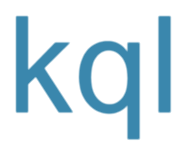

In [1]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

### Login to the log analytics workspace

Retrieve the `LOG_ANALYTICS_WORKSPACE_ID` using the instructions provided above. Please **note**, the log analytics workspace-id is the `workspace-id` of the log analytics workspace, **not** your Bonsai workspace!


In [2]:
LOG_ANALYTICS_WORKSPACE_ID = "ea345eb0-8961-48c2-8656-be7a73f0df32"
ALIAS = 'jomcdowe' # could be anything, but should not be empty
%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

## Iteration and Episode Level Logs

There are four tables generated by the Bonsai service and sent to your Log Analytics workspace. These are:

1. `EpisodeLog_CL` which contains your episode-level logs, such as information about the starting simulator configuration of your episodes, your aggregate goal metrics, etc.
2. `IterationLog_CL` which contains the interation-level logs of your simulator, including the actions received from the platform, and the states emitted from your simulators.
3. `ContainerEvent_CL` (**only for managed simulators that were logged with system logs**): container event logs such as image pull time, build time, etc.
4. `ContainerInstanceLog_CL` (**only for managed simulators that were logged with system logs**): system logs from your simulators.

Let's extract both iteration (`IterationLog_CL`) and episode-level (`EpisodeLog_CL`) logs and join them together via a KQL query. We then export the query results to a pandas dataframe which we can then manipulate and analyze.

**Note**: if this is the first time you're using logging you may need to wait for the first episode to finish so that episode-level logs are created and filled with at least 1 row of data.

### Specify Query Variables and Query

In order to make our query specific to a brain version and brain name, we can create variables containing those values. The following cell does exactly that, and in addition specific a max number of rows to query.

<div class="alert alert-block alert-danger">
<b>WARNING: KQL queries are case-sensitive and the data stored in your analytics workspace is saved as lowercase strings. Brain name and assessment name must be set as lowercase or the query options noted below will fail to find any data.
</div>

In [34]:
number_of_rows = 100000
brain_name = "scg-fun".lower()
brain_version = 28

#### Query

Here is our `KQL` query. Observe that we first filter the `EpisodeLog_CL` table to the brain name and brain version we defined above, and then join it with the `IterationLog_CL` table using the unique `EpisodeId_g` index. Finally, we select (using `project`) a set of columns we want to retain in our resulting dataframe.

In [35]:
%%kql
let _number_of_rows = number_of_rows;
let _brain_name = brain_name;
let _brain_version = brain_version;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version
  | where  TimeGenerated > ago(60d)
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
      ) on EpisodeId_g
  | take _number_of_rows
  | project 
      Timestamp = Timestamp_t,
      SessionIndex = SessionId_s,
      EpisodeIndex = EpisodeIndex_d,
      IterationIndex = IterationIndex_d,
      EpisodeType_s = EpisodeType_s,
      BrainName = BrainName_s,
      BrainVersion = BrainVersion_d,
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      SimConfig = parse_json(SimConfig_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      Terminal = Terminal_b,
      LessonIndex = LessonIndex_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      EpisodeType = EpisodeType_s,
      FinishReason = FinishReason_s
  | order by SessionIndex, EpisodeIndex asc, IterationIndex asc

Timestamp,SessionIndex,EpisodeIndex,IterationIndex,EpisodeType_s,BrainName,BrainVersion,SimState,SimAction,SimConfig,Reward,CumulativeReward,Terminal,LessonIndex,GoalMetrics,EpisodeType,FinishReason
2021-09-29 09:29:41.255000+00:00,934870688_10.244.55.184,16,2,Training,scg-fun,28,"{'deltaMI_201': 0.6434300488240556, 'deltaMI_201_past': 2.441827368824056, 'deltaMI_221': -0.955787886605724, 'deltaMI_221_past': -1.272494886605724, 'C2': 55500, 'BR_201': 55, 'BR_221': 45, 'Density_221': 0.952942, 'current_H2_201': 0.192784342407627, 'current_H2_221': 0.19106857255490625, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.31685714285714284, 'MI_201': 237.840873, 'MI_221': 0.167526, 'MI_201_target_range_low': 131.3263656763917, 'MI_201_target_range_high': 151.3263656763917, 'MI_221_target_range_low': 0.411121962201908, 'MI_221_target_range_high': 0.561121962201908, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 12.129219686918258, 'sim_action_H2_221': 0.9553428627745312, 'sim_action_BR_201': 55, 'sim_action_BR_221': 45, 'sim_action_BR_241': 0, 'sim_action_C2': 55500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 1, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.8252812764177482, 'terminal_value': False}","{'H2_221': 0.35479971766471863, 'H2_201': -0.9615897536277772}",{'sigma': 5},0.825281322002411,46.0430946350098,False,1,{},Training,Terminal
2021-09-29 09:31:29.791000+00:00,934870688_10.244.55.184,16,3,Training,scg-fun,28,"{'deltaMI_201': 0.1857058688240556, 'deltaMI_201_past': 0.6434300488240556, 'deltaMI_221': -0.412994886605724, 'deltaMI_221_past': -0.955787886605724, 'C2': 55500, 'BR_201': 55, 'BR_221': 45, 'Density_221': 0.952479, 'current_H2_201': 0.22502461149239844, 'current_H2_221': 0.21134824579350156, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.35642857142857143, 'MI_201': 169.182246, 'MI_221': 0.348457, 'MI_201_target_range_low': 131.3263656763917, 'MI_201_target_range_high': 151.3263656763917, 'MI_221_target_range_low': 0.411121962201908, 'MI_221_target_range_high': 0.561121962201908, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 14.15764845665574, 'sim_action_H2_221': 1.0567412289675078, 'sim_action_BR_201': 55, 'sim_action_BR_221': 45, 'sim_action_BR_241': 0, 'sim_action_C2': 55500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 2, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.9273066118307643, 'terminal_value': False}","{'H2_221': 0.06083901971578598, 'H2_201': 0.09672080725431442}",{'sigma': 5},0.927306592464447,46.0430946350098,False,1,{},Training,Terminal
2021-09-29 09:33:39.603000+00:00,934870688_10.244.55.184,16,4,Training,scg-fun,28,"{'deltaMI_201': -0.02431757117594424, 'deltaMI_201_past': 0.1857058688240556, 'deltaMI_221': -0.5347828866057243, 'deltaMI_221_past': -0.412994886605724, 'C2': 55500,

[{'Timestamp': datetime.datetime(2021, 9, 29, 9, 29, 41, 255000, tzinfo=tzutc()), 'SessionIndex': '934870688_10.244.55.184', 'EpisodeIndex': 16, 'IterationIndex': 2, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 28, 'SimState': {'deltaMI_201': 0.6434300488240556, 'deltaMI_201_past': 2.441827368824056, 'deltaMI_221': -0.955787886605724, 'deltaMI_221_past': -1.272494886605724, 'C2': 55500, 'BR_201': 55, 'BR_221': 45, 'Density_221': 0.952942, 'current_H2_201': 0.192784342407627, 'current_H2_221': 0.19106857255490625, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.31685714285714284, 'MI_201': 237.840873, 'MI_221': 0.167526, 'MI_201_target_range_low': 131.3263656763917, 'MI_201_target_range_high': 151.3263656763917, 'MI_221_target_range_low': 0.411121962201908, 'MI_221_target_range_high': 0.561121962201908, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 12.129219686918258, 'sim_action_H2_221': 0.9553428627745312, 'sim_action_BR_201': 55, 'sim_action_BR_221': 45, 'sim_action_BR_241': 0, 'sim_action_C2': 55500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 1, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.8252812764177482, 'terminal_value': False}, 'SimAction': {'H2_221': 0.35479971766471863, 'H2_201': -0.9615897536277772}, 'SimConfig': {'sigma': 5}, 'Reward': 0.825281322002411, 'CumulativeReward': 46.0430946350098, 'Terminal': False, 'LessonIndex': 1, 'GoalMetrics': {}, 'EpisodeType': 'Training', 'FinishReason': 'Terminal'},
 {'Timestamp': datetime.datetime(2021, 9, 29, 9, 31, 29, 791000, tzinfo=tzutc()), 'SessionIndex': '934870688_10.244.55.184', 'EpisodeIndex': 16, 'IterationIndex': 3, 'EpisodeType_s': 'Training', 'BrainName': 'scg-fun', 'BrainVersion': 28, 'SimState': {'deltaMI_201': 0.1857058688240556, 'deltaMI_201_past': 0.6434300488240556, 'deltaMI_221': -0.412994886605724, 'deltaMI_221_past': -0.955787886605724, 'C2': 55500, 'BR_201': 55, 'BR_221': 45, 'Density_221': 0.952479, 'current_H2_201': 0.22502461149239844, 'current_H2_221': 0.21134824579350156, 'current_C4_221': 0.5699500000000001, 'deltaPressure': 0.35642857142857143, 'MI_201': 169.182246, 'MI_221': 0.348457, 'MI_201_target_range_low': 131.3263656763917, 'MI_201_target_range_high': 151.3263656763917, 'MI_221_target_range_low': 0.411121962201908, 'MI_221_target_range_high': 0.561121962201908, 'C2_target_range': [55490, 55510], 'BR_201_target_range': [55, 55], 'BR_221_target_range': [45, 45], 'action_range_H2_201': [0, 62.916], 'action_range_H2_221': [0, 5], 'action_range_C2': [30000, 57000], 'action_range_C4_241': [0, 500], 'action_range_C4_221': [0, 1200], 'action_range_BR_201': [0, 100], 'action_range_BR_241': [0, 100], 'action_range_BR_221': [0, 100], 'sim_action_H2_201': 14.15764845665574, 'sim_action_H2_221': 1.0567412289675078, 'sim_action_BR_201': 55, 'sim_action_BR_221': 45, 'sim_action_BR_241': 0, 'sim_action_C2': 55500, 'sim_action_C4_221': 683.94, 'sim_action_C4_241': 0, 'obs_range_MI_201': [0, 900], 'obs_range_MI_221': [0, 2], 'obs_range_C2': [30000, 57000], 'obs_range_BR_201': [0, 100], 'obs_range_BR_221': [0, 100], 'obs_range_Density_221': [0.935, 0.968], 'pressure_error': False, 'step_count': 2, 'max_iteration': 20, 'sim_time': 60, 'sim_error': False, 'reward_value': 0.9273066118307643, 'terminal_value': False}, 'SimAction': {'H2_221': 0.06083901971578598, 'H2_201': 0.09672080725431442}, 'SimConfig': {'sigma': 5}, 'Reward':

### Magic

Magically, the output of the result is saved to a new python variable called `_kql_raw_result`. We can convert this to a pandas dataframe:

In [36]:
# convert query results in a dataframe
iter_df = _kql_raw_result_.to_dataframe()
iter_df.head(5)

,Timestamp,SessionIndex,EpisodeIndex,IterationIndex,EpisodeType_s,BrainName,BrainVersion,SimState,SimAction,SimConfig,Reward,CumulativeReward,Terminal,LessonIndex,GoalMetrics,EpisodeType,FinishReason
0,2021-09-29 09:29:41.255000+00:00,934870688_10.244.55.184,16.0,2.0,Training,scg-fun,28.0,"{'deltaMI_201': 0.6434300488240556, 'deltaMI_2...","{'H2_221': 0.35479971766471863, 'H2_201': -0.9...",{'sigma': 5},0.825281,46.043095,False,1.0,{},Training,Terminal
1,2021-09-29 09:31:29.791000+00:00,934870688_10.244.55.184,16.0,3.0,Training,scg-fun,28.0,"{'deltaMI_201': 0.1857058688240556, 'deltaMI_2...","{'H2_221': 0.06083901971578598, 'H2_201': 0.09...",{'sigma': 5},0.927307,46.043095,False,1.0,{},Training,Terminal
2,2021-09-29 09:33:39.603000+00:00,934870688_10.244.55.184,16.0,4.0,Training,scg-fun,28.0,"{'deltaMI_201': -0.02431757117594424, 'deltaMI...","{'H2_201': 0.04314478486776352, 'H2_221': -0.0...",{'sigma': 5},0.914642,46.043095,False,1.0,{},Training,Terminal
3,2021-09-29 09:35:40.082000+00:00,934870688_10.244.55.184,16.0,5.0,Training,scg-fun,28.0,"{'deltaMI_201': -0.08853574450927715, 'deltaMI...","{'H2_221': 0.3315725326538086, 'H2_201': 0.137...",{'sigma': 5},0.975937,46.043095,False,1.0,{},Training,Terminal
4,2021-09-29 09:37:47.440000+00:00,934870688_10.244.55.184,16.0,6.0,Training,scg-fun,28.0,"{'deltaMI_201': -0.07069032450927759, 'deltaMI...","{'H2_221': -0.07465056329965591, 'H2_201': 0.2...",{'sigma': 5},0.956781,46.043095,False,1.0,{},Training,Terminal


## Converting Nested Array Into New Columns

Notice that the array-data as stored in `SimState`, `SimAction` and `SimConfig` are dictionaries. You can cast them into new columns using the operations below:

In [37]:
import pandas as pd
def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "SimState", "SimAction", "SimConfig", "SessionIndex"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["Timestamp","EpisodeIndex", "IterationIndex", "Reward", "Terminal", "IterationSpeed_s", "SessionIndex"]
    for i in nested_columns:
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime
    formated_df['IterationSpeed_s']=formated_df['Timestamp'].diff().dt.total_seconds() # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df.sort_values(by=["EpisodeIndex", "IterationIndex"])


In [38]:
df = format_kql_logs(iter_df)

In [39]:
df.describe()

,EpisodeIndex,IterationIndex,Reward,IterationSpeed_s,deltaMI_201,deltaMI_201_past,deltaMI_221,deltaMI_221_past,C2,BR_201,...,sim_action_C2,sim_action_C4_221,sim_action_C4_241,step_count,max_iteration,sim_time,reward_value,H2_221,H2_201,sigma
count,36581.000000,36581.000000,36581.000000,36580.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,...,36581.000000,3.658100e+04,36581.0,36581.000000,36581.0,36581.0,36581.000000,31472.000000,31472.000000,36581.0
mean,40.620049,6.760313,6.604518,3.611536,0.665643,1.013669,-0.524381,-0.696547,54958.120336,54.110071,...,55081.012001,6.839400e+02,0.0,5.760313,20.0,60.0,6.692438,0.040205,-0.089981,5.0
std,33.344547,5.902688,16.342082,219.462248,0.873305,1.014942,1.131821,1.110767,2789.987568,3.182962,...,1039.924332,2.273768e-13,0.0,5.902688,0.0,0.0,16.307970,0.399338,0.475946,0.0
min,1.000000,1.000000,-1.000000,0.000000,-0.979408,-0.429101,-1.559373,-1.413241,0.000000,0.000000,...,52500.000000,6.839400e+02,0.0,0.000000,20.0,60.0,-1.000000,-1.000000,-1.000000,5.0
25%,12.000000,2.000000,0.772115,0.160000,0.028963,0.141588,-1.258221,-1.295759,55500.000000,55.000000,...,55500.000000,6.839400e+02,0.0,1.000000,20.0,60.0,0.772115,-0.191476,-0.422070,5.0
50%,23.000000,4.000000,0.823462,0.636000,0.283013,0.628235,-0.840865,-1.081166,55500.000000,55.000000,...,55500.000000,6.839400e+02,0.0,3.000000,20.0,60.0,0.823462,0.039467,-0.040637,5.0
75%,68.000000,11.000000,0.931345,1.588250,0.932173,2.427495,-0.084685,-0.453414,55500.000000,55.000000,...,55500.000000,6.839400e+02,0.0,10.000000,20.0,60.0,0.931345,0.315870,0.244415,5.0
max,156.000000,21.000000,55.500000,39976.109000,3.324806,3.324806,17.072526,16.891550,55500.000000,55.000000,...,55500.000000,6.839400e+02,0.0,20.000000,20.0,60.0,55.500000,1.000000,1.000000,5.0


In [ ]:
len(df['SessionIndex'].unique())

In [ ]:
df.sort_values(by=["EpisodeIndex", "IterationIndex"])

In [ ]:
# per step reward
df.hist(column='reward_value', bins=10)

In [ ]:
df_last = pd.DataFrame({})
for sess in iter_df['SessionIndex'].unique():
    df_sess = iter_df[iter_df['SessionIndex']==sess]
    for ep in range(1, int(iter_df['EpisodeIndex'].max()+1)):
        last_iter = df_sess[ (df_sess['EpisodeIndex']==ep) & (df_sess['IterationIndex'] == len(df_sess[df_sess['EpisodeIndex']==ep]))]
        df_last = pd.concat([df_last, last_iter], sort=False)

In [ ]:
df_last = format_kql_logs(df_last)

In [ ]:
# episode return reward
df_last.hist(column='reward_value', bins=10)

# Ranges through # of samples

In [ ]:
df_review = pd.DataFrame({})

cols = [
    'SessionIndex',
    'EpisodeIndex',
    'IterationIndex',
    'Terminal',
    'deltaMI_201',
    'deltaMI_221',
    'current_H2_201',
    'current_H2_221',
    'deltaPressure',
    'MI_201',
    'MI_221',
    'C2',
    'BR_201',
    'BR_221',
    'Density_221',
    'MI_201_target_range_low',
    'MI_201_target_range_high',
    'MI_221_target_range_low',
    'MI_221_target_range_high',
    'step_count',
    'pressure_error',
    'sim_error',
    'sim_action_H2_201',
    'sim_action_H2_221',
    'sim_action_C2',
    'sim_action_C4_241',
    'sim_action_C4_221',
    'sim_action_BR_201',
    'sim_action_BR_241',
    'sim_action_BR_221',
    'H2_201',
    'H2_221',
]

state_cols = [
    'deltaMI_201',
    'deltaMI_221',
    'current_H2_201',
    'current_H2_221',
    'deltaPressure',
    'MI_201',
    'MI_221',
    'C2',
    'BR_201',
    'BR_221',
    'Density_221',
    'MI_201_target_range_low',
    'MI_201_target_range_high',
    'MI_221_target_range_low',
    'MI_221_target_range_high',
    'step_count',
    'pressure_error',
    'sim_error',
    'sim_action_H2_201',
    'sim_action_H2_221',
    'sim_action_C2',
    'sim_action_C4_241',
    'sim_action_C4_221',
    'sim_action_BR_201',
    'sim_action_BR_241',
    'sim_action_BR_221',
]

action_cols = [
    'H2_201',
    'H2_221',
]

config_cols = [
]

for sess in iter_df['SessionIndex'].unique():
#for sess in ['149204247_10.244.8.228']:
    print("doing sess {}".format(sess))
    df_session = iter_df[iter_df['SessionIndex'] == sess]
    df_session = format_kql_logs(df_session)
    df_session.sort_values(by=["EpisodeIndex", "IterationIndex"])
    for ep in range(1, int(max(df_session['EpisodeIndex']))+1):
    #for ep in range(5, 6):
        print("doing ep {}".format(ep))
        df_flat = df_session[df_session['EpisodeIndex'] == ep]
        if len(df_flat) > 1:
            if df_flat['IterationIndex'].iloc[1] == 1:
                print('Truncating ep because duplicate')
            elif df_flat['IterationIndex'].iloc[0] == 1:
                df_flat = df_flat[cols]
                df_review = pd.concat([df_review, df_flat])
                df_review['pressure_error'] = df_review['pressure_error'].map(int)
                df_review['sim_error'] = df_review['sim_error'].map(int)
            else:
                print('Truncating ep because did not start at IterationIndex=1')
        else:
            print('Empty episode')

In [ ]:
for col in state_cols:
    print(df_review[col].describe())

In [ ]:
#ranges_to_eval = [5000, 20000, 40000, 80000]
ranges_to_eval = [5000, 10000, 20000, 36228]
df_dict = {}
for i in range(len(ranges_to_eval)):
    rng_to_slice = int(1.2 * ranges_to_eval[i])
    df_dict[str(ranges_to_eval[i])] = df_review[:rng_to_slice]

In [ ]:
def plot_ranges(ranges_to_eval, state_cols, dfs):
    import matplotlib.pyplot as plt
    col_maxes = pd.DataFrame({})
    col_mins = pd.DataFrame({})
    for key, df in dfs.items():
        temp_max_df = {}
        temp_min_df = {}
        for col in state_cols:
            temp_max_df[col] = [df[col].describe()["max"]]
            temp_min_df[col] = [df[col].describe()["min"]]
        col_maxes = pd.concat([col_maxes, pd.DataFrame(temp_max_df)])
        col_mins = pd.concat([col_mins, pd.DataFrame(temp_min_df)])
    
    for col in state_cols:
        fig, ax = plt.subplots(1, 1)
        ax.plot(ranges_to_eval, col_maxes[col], marker='*', label=str(col)+'_max')
        ax.plot(ranges_to_eval, col_mins[col], marker='*', label=str(col)+'_min')
        
        ax.legend()
        plt.show()

In [ ]:
plot_ranges(ranges_to_eval, state_cols, df_dict)

# Convert subset to NeuralSim Dev tool

In [ ]:
num_samples = 20000
df_to_convert = df_dict[str(num_samples)]

In [ ]:
import os
import numpy as np
import random

isdir = os.path.isdir("training")
if isdir:
    pass
else:
    os.makedirs("training")
    
isdir = os.path.isdir("validation")
if isdir:
    pass
else:
    os.makedirs("validation")

In [ ]:
for sess in df_to_convert['SessionIndex'].unique():
    print("doing sess {}".format(sess))
    df_session = df_to_convert[df_to_convert['SessionIndex'] == sess]
    df_session.sort_values(by=["EpisodeIndex", "IterationIndex"])
    for ep in df_session['EpisodeIndex'].unique():
        print("doing ep {}".format(ep))
        df_flat = df_session[df_session['EpisodeIndex'] == ep]
        df_flat = df_flat[cols]
        df_ep = pd.DataFrame({})
        df_ep['EpisodeIndex'] = '"' + sess + '_ep_' +df_flat['EpisodeIndex'].map(str) + '"'
        df_ep['IterationIndex'] = df_flat['IterationIndex'].astype(int)
        df_ep['is_initial_state'] = df_flat.eval("IterationIndex == 1")
        df_ep['is_terminal_state'] = df_flat['Terminal']
        df_ep['is_initial_state'] = df_ep['is_initial_state'].replace(True, 'true')
        df_ep['is_initial_state'] = df_ep['is_initial_state'].replace(False, 'false')
        df_ep['is_terminal_state'] = df_ep['is_terminal_state'].replace(True, 'true')
        df_ep['is_terminal_state'] = df_ep['is_terminal_state'].replace(False, 'false')
        df_ep['state'] = df_flat[state_cols].to_numpy().tolist()
        df_ep['action'] = df_flat[action_cols].to_numpy().tolist()
        df_ep['action'].iloc[0] = []
        df_ep['config'] = df_flat[config_cols].to_numpy().tolist()
        # since empty config, need 0
        df_ep['config'] = df_ep['config'].apply(lambda x: x if x else 0)
        if np.random.uniform(0, 1) <= 0.1:
            df_ep.to_csv('./validation/{}_ep_{}.csv'.format(sess, int(ep)), index=False, header=False)
        else:
            df_ep.to_csv('./training/{}_ep_{}.csv'.format(sess, int(ep)), index=False, header=False)

In [ ]:
import glob, os
import shutil

training_data_count = 0
parent_dir = './training'
for file in glob.glob(os.path.join(parent_dir, '*.csv')):
    with open(file) as fname:
        df = pd.read_csv(fname)
    training_data_count += len(df)

parent_dir = './validation'

broken = False
while training_data_count < num_samples:
    for file in glob.glob(os.path.join(parent_dir, '*.csv')):
        with open(file) as fname:
            df = pd.read_csv(fname)
        data_count = len(df)
        if training_data_count + data_count < num_samples:
            training_data_count += data_count
            shutil.move(file, './training')
        else:
            training_data_count += data_count
            shutil.move(file, './training')
            print('Increased training dataset size from validation set to {}'.format(training_data_count))
            broken = True
            break
    if broken:
        break
    if glob.glob(os.path.join(parent_dir, '*.csv')):
        pass
    else:
        print('Out of files')
        print('Training dataset size now: {}'.format(training_data_count))
        break

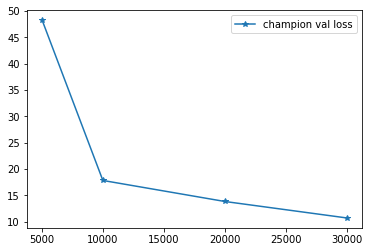

In [17]:
n_training_data = [5017, 10000, 20017, 30002]
champion_val_data = [48.22986602783203, 17.79674784342448, 13.800888061523438, 10.681306665593928]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

ax.plot(n_training_data, champion_val_data, label='champion val loss', marker='*')
ax.legend()
plt.show()